# **DATA COLLECTION, INFORMATION, AND PREPARATION**

In [ ]:
from google.colab import files
import pandas as pd

# Prompt upload (pick Ethos_Apartment_Group.csv from your computer)
uploaded = files.upload()

# Read it into a DataFrame
for fn in uploaded.keys():
    df = pd.read_csv(fn)

print("Shape:", df.shape)
df.head()

Saving Ethos_Apartment_Group.csv to Ethos_Apartment_Group.csv
Shape: (498, 11)


,Owner no.,Type,Capacity,Bedroom,Kitchen,Kitchen type,Gender specific,Pets,Unit Size,Price p/month,Location
0,Owner1,Studio type,6,1,Yes,Gas,No,No,18 sqm,P8000,"Pasig, San Jose"
1,NaN,Apartment,4,1,Yes,Gas,No,No,20 sqm,"P12,000","Pasig, San Jose"
2,NaN,Apartment,4,1,Yes,Gas,No,No,20 sqm,"P13,000","Pasig, San Jose"
3,Owner2,Studio type,3,2,Yes,Gas,no,No,13 sqm,-,Pasig City
4,Owner3,Studio type,3,0,Yes,Electric,No,No,30~ sqm,"P15,000",Sta.ana Manila


In [ ]:
# Purpose: Import libraries, load CSV, and preview schema.

import os, json, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor

import matplotlib.pyplot as plt
import joblib

# After upload, `df` is already loaded.
# If you prefer to keep a variable:
DATA_FILE = list(uploaded.keys())[0]
RANDOM_STATE = 42
N_JOBS = -1  # Colab CPU can handle -1; set to 1 if hitting resource limits

df = pd.read_csv(DATA_FILE)
print("Shape:", df.shape)
df.head()

Shape: (498, 11)


,Owner no.,Type,Capacity,Bedroom,Kitchen,Kitchen type,Gender specific,Pets,Unit Size,Price p/month,Location
0,Owner1,Studio type,6,1,Yes,Gas,No,No,18 sqm,P8000,"Pasig, San Jose"
1,NaN,Apartment,4,1,Yes,Gas,No,No,20 sqm,"P12,000","Pasig, San Jose"
2,NaN,Apartment,4,1,Yes,Gas,No,No,20 sqm,"P13,000","Pasig, San Jose"
3,Owner2,Studio type,3,2,Yes,Gas,no,No,13 sqm,-,Pasig City
4,Owner3,Studio type,3,0,Yes,Electric,No,No,30~ sqm,"P15,000",Sta.ana Manila


# **DATA CLEANING AND PARSING**

In [ ]:
# Purpose: Convert 'Price p/month' → numeric 'price'; normalize 'Unit Size' → 'unit_sqm';
# trim consistent categories.

def parse_price(val):
    if pd.isna(val): return np.nan
    s = str(val).strip().replace("P","").replace(",","").strip()
    try:
        return float(s)
    except:
        return np.nan

def parse_sqm(val):
    if pd.isna(val): return np.nan
    s = str(val).lower().replace("sqm","").replace("~","").strip().replace("²","")
    # try direct float
    try:
        return float(s)
    except:
        # fallback: read leading digits
        num = "".join(ch for ch in s if ch.isdigit() or ch==".")
        try:
            return float(num) if num else np.nan
        except:
            return np.nan

# Create clean numeric target and numeric unit size
df["price"] = df["Price p/month"].apply(parse_price)
df["unit_sqm"] = df["Unit Size"].apply(parse_sqm)

# Standardize some categorical columns (spacing/case)
for c in ["Kitchen","Gender specific","Pets","Type","Kitchen type","Location"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# Remove duplicates and rows without target or crucial inputs
df = df.drop_duplicates()
must_have = ["Capacity","Bedroom","unit_sqm","Type","Kitchen","Kitchen type","Gender specific","Pets","Location","price"]
df = df.dropna(subset=must_have)

print("After cleaning:", df.shape)
df[must_have].head()

After cleaning: (426, 13)


,Capacity,Bedroom,unit_sqm,Type,Kitchen,Kitchen type,Gender specific,Pets,Location,price
0,6,1,18.0,Studio type,Yes,Gas,No,No,"Pasig, San Jose",8000.0
1,4,1,20.0,Apartment,Yes,Gas,No,No,"Pasig, San Jose",12000.0
2,4,1,20.0,Apartment,Yes,Gas,No,No,"Pasig, San Jose",13000.0
4,3,0,30.0,Studio type,Yes,Electric,No,No,Sta.ana Manila,15000.0
5,3,0,30.0,Studio type,Yes,Electric,No,No,Sta.ana Manila,15000.0


# **FEATURE ENGINEERING & TRAIN/TEST SPLIT**

In [ ]:
# Purpose: Define features, create a helpful ratio feature, then split with price-based stratification.

# Base features mapped to your columns
numeric_base   = ["Capacity","Bedroom","unit_sqm"]
categorical_in = ["Type","Kitchen","Kitchen type","Gender specific","Pets","Location"]

X = df[numeric_base + categorical_in].copy()
y = df["price"].astype(float)

# Derived feature: occupants per bedroom (fallback to capacity if Bedroom==0)
X["cap_per_bedroom"] = X["Capacity"] / X["Bedroom"].replace(0, np.nan)
X["cap_per_bedroom"] = X["cap_per_bedroom"].fillna(X["Capacity"])

# Final lists for the transformer
numeric_cols     = ["Capacity","Bedroom","unit_sqm","cap_per_bedroom"]
categorical_cols = categorical_in

# Stratify by price bins for a balanced evaluation
price_bins = pd.qcut(y, q=min(8, y.nunique()), duplicates="drop")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=price_bins
)

X_train.shape, X_test.shape

((340, 10), (86, 10))

# **DATA PREPROCESSING**

In [ ]:
# Purpose: Impute + scale numeric; impute + one-hot encode categoricals.

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=5))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, numeric_cols),
        ("cat", categorical_tf, categorical_cols),
    ],
    remainder="drop"
)

preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Capacity', 'Bedroom', 'unit_sqm',
                                  'cap_per_bedroom']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                min_frequency=5))]),
                                 ['Type', 'Kitchen', 'Kitchen type',
                                  'Gender specific', 'Pets', 'Location'])])

# **DATA PREPROCESSING VISUALIZATION**

In [ ]:
import pandas as pd

# Fit the preprocessor on training data only
preprocess.fit(X_train)

# Transform both train and test sets
X_train_transformed = preprocess.transform(X_train)
X_test_transformed  = preprocess.transform(X_test)

# Get feature names after preprocessing
feature_names = []
# Numeric features keep their names
feature_names.extend(numeric_cols)

# OneHotEncoder expands categoricals
ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
feature_names.extend(cat_names)

# Build DataFrames
X_train_df = pd.DataFrame(X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed,
                          columns=feature_names, index=X_train.index)

X_test_df = pd.DataFrame(X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed,
                         columns=feature_names, index=X_test.index)

print("Cleaned & Encoded Training Set for Model Training (first 10 rows):")
display(X_train_df.head(10))

print("Shape after preprocessing:", X_train_df.shape)

Cleaned & Encoded Training Set for Model Training (first 10 rows):


,Capacity,Bedroom,unit_sqm,cap_per_bedroom,Type_Apartment,Type_Condo unit,Type_Studio type,Kitchen_Yes,Kitchen type_Electric,Kitchen type_Gas,...,Location_Pasig City,"Location_Pasig, Bagong Ilog","Location_Pasig, San Jose","Location_Pinalad Rd, Pinagbuhatan,Pasig",Location_Quezon City,"Location_Sampaloc, Manila City",Location_Sta.ana Manila,Location_Taguig City,Location_Valenzuela City,Location_infrequent_sklearn
334,1.416304,1.442308,-0.388776,-0.592564,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
310,1.416304,1.442308,-0.388776,-0.592564,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
46,1.416304,1.442308,8.257217,-0.592564,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,1.416304,-0.315343,-0.970718,1.951003,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
70,0.004153,-1.194169,-0.388776,0.679220,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
375,-1.407997,0.563482,-0.388776,-1.228456,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,0.710229,-1.194169,-0.970718,1.315112,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
439,0.710229,0.563482,0.276300,-0.274618,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
376,0.710229,-0.315343,1.273915,1.315112,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
332,-1.407997,-0.315343,-0.721315,-0.592564,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Shape after preprocessing: (340, 40)


# **MODEL BUILDING (BAGGING)**

In [ ]:
# Purpose: Compare linear, tree, nonparametric, and ensemble models fairly.
# Hyperparameter grids are kept modest for your dataset size.

import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score

models = { # Bagging was chosen as the best model for HanapBahay
    "Bagging": (BaggingRegressor(random_state=RANDOM_STATE, n_estimators=300, n_jobs=N_JOBS),
                {"model__max_samples": [0.6,0.8,1.0],
                 "model__max_features": [0.6,0.8,1.0]}),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []
best_model_name, best_cv_rmse, best_estimator = None, np.inf, None

for name, (est, param_space) in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", est)])

    if param_space:
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_space,
            n_iter=min(25, sum(len(v) if hasattr(v, "__len__") else 10 for v in param_space.values())),
            cv=cv,
            scoring="neg_root_mean_squared_error",
            n_jobs=N_JOBS,
            random_state=RANDOM_STATE,
            verbose=0,
        )
        search.fit(X_train, y_train)
        estimator = search.best_estimator_
        cv_rmse = -search.best_score_
        cfg = search.best_params_
    else:
        # pure CV for LinearRegression (no params)
        scores = cross_val_score(pipe, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=N_JOBS)
        estimator = pipe.fit(X_train, y_train)
        cv_rmse = -np.mean(scores)
        cfg = {}

    # holdout evaluation
    y_pred = estimator.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    test_mse = mse
    test_rmse = np.sqrt(mse)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2  = r2_score(y_test, y_pred)

    results.append({"model": name, "cv_rmse": cv_rmse, "test_rmse": test_rmse,
                "test_mse": test_mse, "test_mae": test_mae, "test_r2": test_r2, "best_params": cfg})


    if cv_rmse < best_cv_rmse:
        best_cv_rmse, best_model_name, best_estimator = cv_rmse, name, estimator

pd.DataFrame(results).sort_values("test_rmse").round(4)

,model,cv_rmse,test_rmse,test_mse,test_mae,test_r2,best_params
0,Bagging,4479.355,4055.7051,1.644874e+07,3158.9793,0.6382,"{'model__max_samples': 0.8, 'model__max_featur..."


# **MODEL LEADERBOARD**

In [ ]:
# Show leaderboard sorted by Test_RMSE
leaderboard = pd.DataFrame(results).sort_values("test_rmse").reset_index(drop=True)
display(leaderboard[["model","cv_rmse","test_rmse","test_mae","test_r2"]].round(4))

best_model_name = leaderboard.loc[0, "model"]
print("Best model during experimentation:", best_model_name)

,model,cv_rmse,test_rmse,test_mae,test_r2
0,Bagging,4479.355,4055.7051,3158.9793,0.6382


Best model during experimentation: Bagging


# **ACCURACY & CLASSIFICATION REPORT**

In [ ]:
# === Classification-style evaluation (Low/Mid/High from train tertiles) ===
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np, pandas as pd

edges = np.quantile(y_train, [0.0, 1/3, 2/3, 1.0])
labels = ["Low","Mid","High"]

def to_band(vals, edges, labels):
    return pd.cut(vals, bins=edges, labels=labels, include_lowest=True, right=True)

y_test_cls = to_band(y_test, edges, labels)
y_pred_best = best_estimator.predict(X_test)
y_pred_cls = to_band(y_pred_best, edges, labels)

acc = accuracy_score(y_test_cls, y_pred_cls)
print(f"Classification-style Accuracy (Low/Mid/High): {acc:.4f}\n")
print("Classification Report (macro-avg is useful if classes are imbalanced):")
print(classification_report(y_test_cls, y_pred_cls, digits=4))

cm = confusion_matrix(y_test_cls, y_pred_cls, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
print("\nConfusion Matrix:")
display(cm_df)

Classification-style Accuracy (Low/Mid/High): 0.7558

Classification Report (macro-avg is useful if classes are imbalanced):
              precision    recall  f1-score   support

        High     0.6970    0.8519    0.7667        27
         Low     0.9583    0.7931    0.8679        29
         Mid     0.6552    0.6333    0.6441        30

    accuracy                         0.7558        86
   macro avg     0.7702    0.7594    0.7596        86
weighted avg     0.7705    0.7558    0.7580        86


Confusion Matrix:


,Pred_Low,Pred_Mid,Pred_High
True_Low,23,6,0
True_Mid,1,19,10
True_High,0,4,23


# **CONFUSION MATRIX**

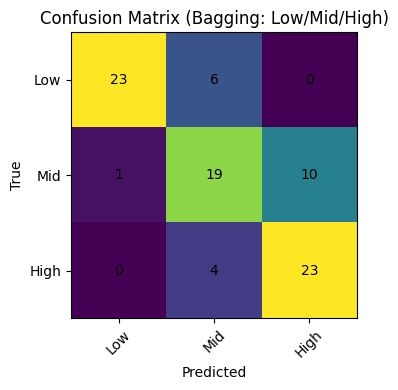

In [ ]:
# === Confusion Matrix Heatmap (Counts) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_cls, y_pred_cls, labels=labels)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Bagging: Low/Mid/High)")
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# (Optional) Save for your slides
# plt.figure(figsize=(5,4))
# plt.imshow(cm, interpolation="nearest")
# plt.title("Confusion Matrix (Counts)")
# plt.xticks(np.arange(len(labels)), labels, rotation=45)
# plt.yticks(np.arange(len(labels)), labels)
# for i in range(cm.shape[0]):
    # for j in range(cm.shape[1]):
        # plt.text(j, i, cm[i, j], ha="center", va="center")
#  plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.tight_layout()
# plt.savefig("confusion_matrix_counts.png", dpi=150)
# plt.close()

In [ ]:
# Print core regression metrics for the best model (Bagging)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = best_estimator.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | R²: {r2:.4f}")

Test RMSE: 4,055.71 | MAE: 3,158.98 | R²: 0.6382


# **MODEL VISUALIZATION**


Leaderboard (lower RMSE is better):


,model,cv_rmse,test_rmse,test_mae,test_r2
0,Bagging,4479.355,4055.7051,3158.9793,0.6382


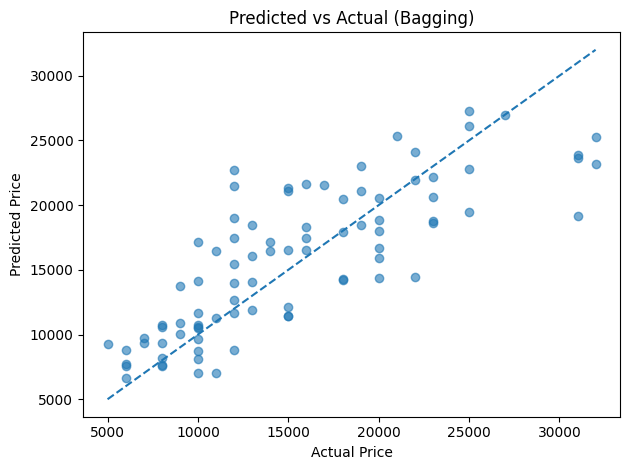

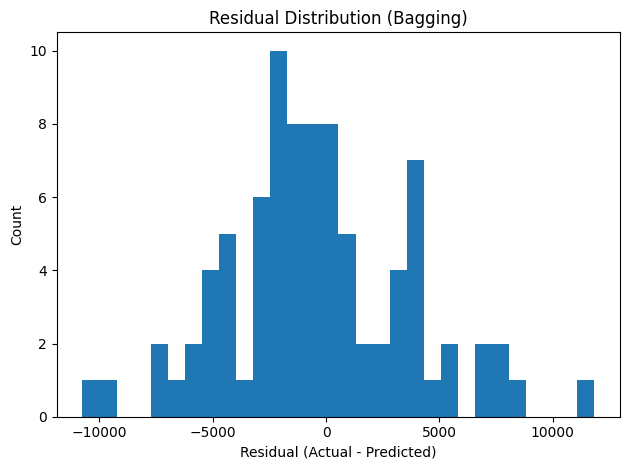

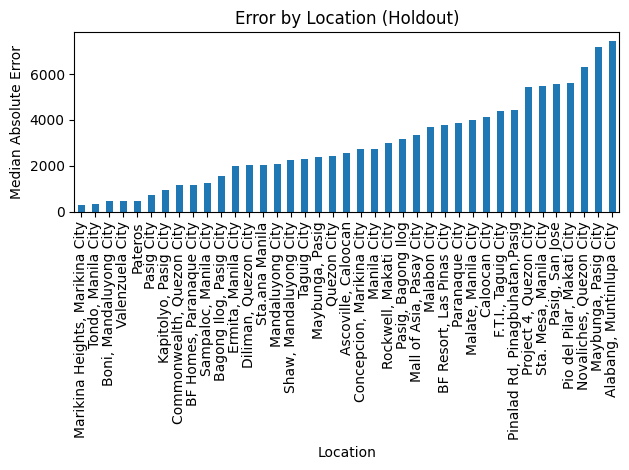

<Figure size 640x480 with 0 Axes>

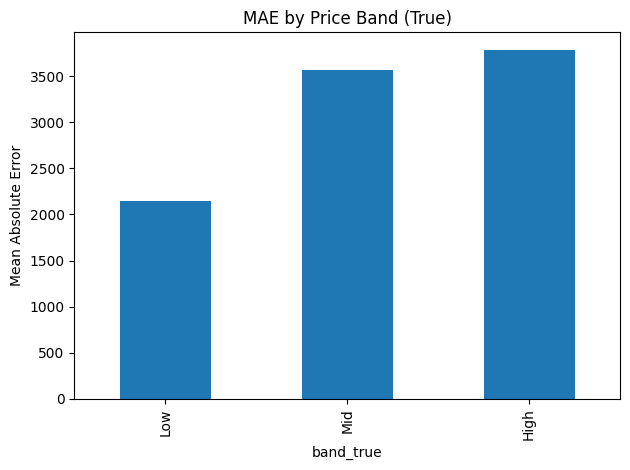

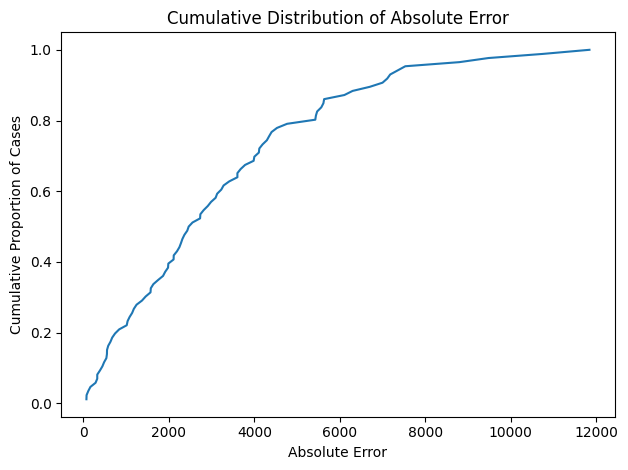

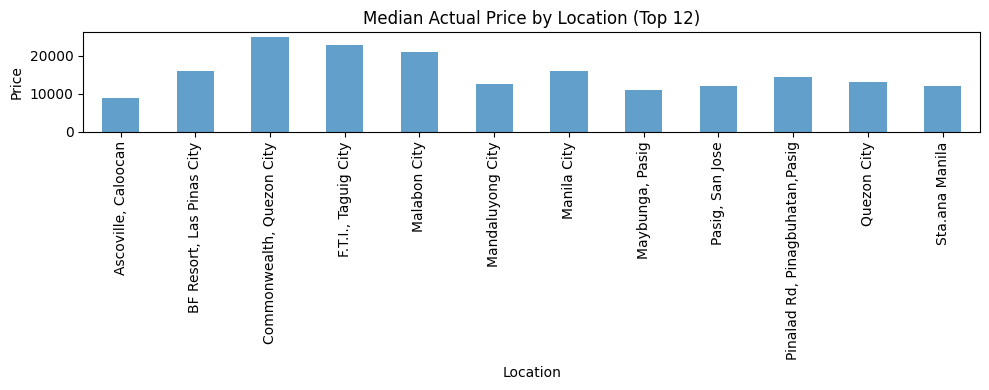

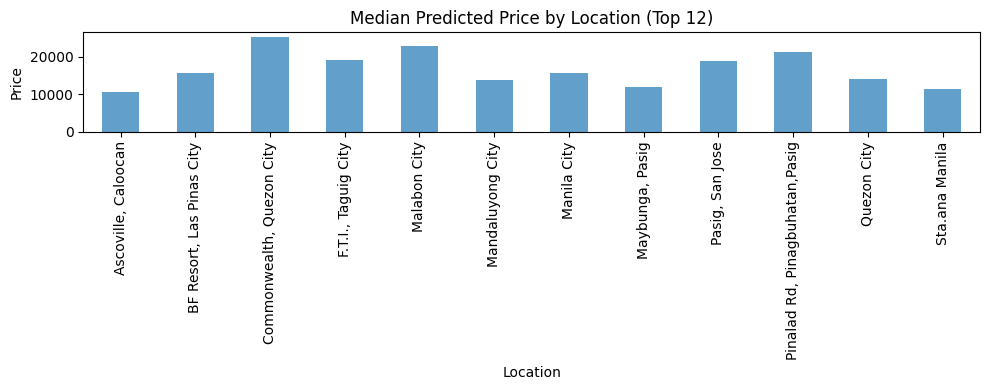

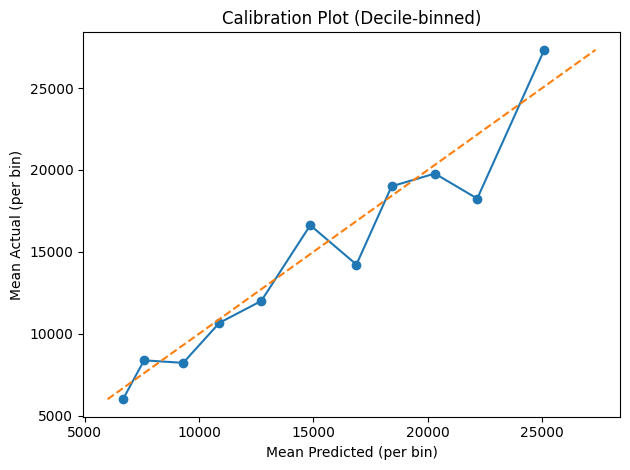

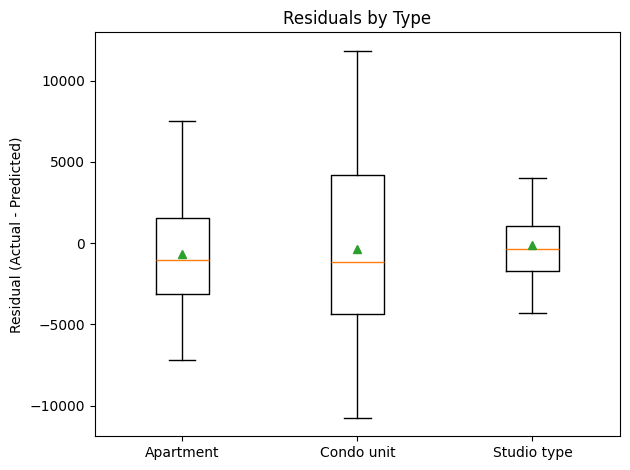



Top-15 Absolute Errors:


,Type,Kitchen,Kitchen type,Gender specific,Pets,Location,Capacity,Bedroom,Actual,Pred,AbsErr
346,Condo unit,Yes,Gas,No,No,"F.T.I., Taguig City",4,3,31000.0,19156.666667,11843.333333
271,Condo unit,Yes,Gas/Electric,No,Yes (Limited to 1),"Pinalad Rd, Pinagbuhatan,Pasig",4,0,12000.0,22750.000000,10750.000000
206,Condo unit,Yes,Gas/Electric,No,Yes (Limited to 1),"Pinalad Rd, Pinagbuhatan,Pasig",4,3,12000.0,21480.000000,9480.000000
451,Condo unit,Yes,Gas,No,No,Mandaluyong City,4,0,32000.0,23200.000000,8800.000000
319,Apartment,Yes,Electric,No,No,"Alabang, Muntinlupa City",5,3,22000.0,14466.666667,7533.333333
349,Condo unit,Yes,Gas,No,Yes (Limited to 1),"Alabang, Muntinlupa City",2,1,31000.0,23643.333333,7356.666667
43,Apartment,Yes,Gas,No,No,"Maybunga, Pasig City",4,1,10000.0,17180.000000,7180.000000
330,Condo unit,Yes,Gas/Electric,No,No,Paranaque City,4,3,31000.0,23890.000000,7110.000000
296,Condo unit,Yes,Gas,No,No,"Pasig, San Jose",5,3,12000.0,19000.000000,7000.000000
384,Condo unit,Yes,Gas,No,Yes,"Commonwealth, Quezon City",6,0,32000.0,25296.666667,6703.333333


In [ ]:
# Purpose: Sanity-check predictive fit and error structure (no seaborn, one plot per figure).

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

res_df = pd.DataFrame(results).sort_values("test_rmse")
print("Leaderboard (lower RMSE is better):")
display(res_df[["model","cv_rmse","test_rmse","test_mae","test_r2"]].round(4))
print("\n")

# Best model predictions on holdout
y_pred_best = best_estimator.predict(X_test)

# 1) Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred_best, alpha=0.6)
lim = [min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())]
plt.plot(lim, lim, linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Predicted vs Actual ({best_model_name})")
plt.tight_layout()
plt.show()
print("\n")

# 2) Residual distribution
residuals = y_test - y_pred_best
plt.figure()
plt.hist(residuals, bins=30)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.title(f"Residual Distribution ({best_model_name})")
plt.tight_layout()
plt.show()
print("\n")

# 3) Error by Location
tmp = pd.DataFrame({"Location": X_test["Location"], "abs_err": np.abs(residuals)})
loc_err = tmp.groupby("Location")["abs_err"].median().sort_values()
plt.figure()
loc_err.plot(kind="bar")
plt.ylabel("Median Absolute Error")
plt.title("Error by Location (Holdout)")
plt.tight_layout()
plt.show()
print("\n")

# 4) Error by Price Band (MAE per Low/Mid/High)
band_df = pd.DataFrame({"band_true": y_test_cls, "abs_err": np.abs(residuals)})
band_mae = band_df.groupby(band_df["band_true"]).agg(MAE=("abs_err","mean")).reindex(labels)
plt.figure()
band_mae.plot(kind="bar", legend=False)
plt.ylabel("Mean Absolute Error")
plt.title("MAE by Price Band (True)")
plt.tight_layout()
plt.show()
print("\n")

# 6) Cumulative Distribution of Absolute Error (ECDF)
abs_err = np.abs(residuals)
sorted_err = np.sort(abs_err)
ecdf = np.arange(1, len(sorted_err)+1) / len(sorted_err)
plt.figure()
plt.plot(sorted_err, ecdf)
plt.xlabel("Absolute Error")
plt.ylabel("Cumulative Proportion of Cases")
plt.title("Cumulative Distribution of Absolute Error")
plt.tight_layout()
plt.show()
print("\n")

# 7) Actual vs Predicted by Location (top 12 frequent locations)
loc_series = X_test["Location"]
top_locs = loc_series.value_counts().head(12).index
ap = pd.DataFrame({
    "Location": X_test["Location"],
    "Actual": y_test,
    "Pred": y_pred_best
})
ap = ap[ap["Location"].isin(top_locs)]
agg = ap.groupby("Location").agg(Actual=("Actual","median"), Pred=("Pred","median"))

plt.figure(figsize=(10,4))
agg["Actual"].plot(kind="bar", alpha=0.7)
plt.title("Median Actual Price by Location (Top 12)")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
agg["Pred"].plot(kind="bar", alpha=0.7)
plt.title("Median Predicted Price by Location (Top 12)")
plt.ylabel("Price")
plt.tight_layout()
plt.show()
print("\n")

# 9) Calibration: Binned Predicted vs Actual (deciles of predicted)
bins = np.quantile(y_pred_best, np.linspace(0,1,11))
bin_ids = np.digitize(y_pred_best, bins, right=True)
cal_df = pd.DataFrame({"pred": y_pred_best, "act": y_test, "bin": bin_ids})
cal_agg = cal_df.groupby("bin").agg(mean_pred=("pred","mean"), mean_act=("act","mean"))

plt.figure()
plt.plot(cal_agg["mean_pred"], cal_agg["mean_act"], marker="o")
lim = [min(cal_agg.values.min(), cal_agg.values.max()),
       max(cal_agg.values.min(), cal_agg.values.max())]
plt.plot(lim, lim, linestyle="--")
plt.xlabel("Mean Predicted (per bin)")
plt.ylabel("Mean Actual (per bin)")
plt.title("Calibration Plot (Decile-binned)")
plt.tight_layout()
plt.show()
print("\n")

# 10) Residuals by Category (Type)
type_res = pd.DataFrame({"Type": X_test["Type"], "res": residuals})
groups = [g.dropna().values for _, g in type_res.groupby("Type")["res"]]
labels_types = [str(k) for k in type_res.groupby("Type").groups.keys()]

plt.figure()
plt.boxplot(groups, labels=labels_types, showmeans=True)
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals by Type")
plt.tight_layout()
plt.show()
print("\n")

# 11) Top-K Largest Errors (table for audit)
k = 15
audit_cols = ["Type","Kitchen","Kitchen type","Gender specific","Pets","Location","Capacity","Bedroom"]
audit_df = pd.DataFrame(X_test[audit_cols]).copy()
audit_df["Actual"] = y_test
audit_df["Pred"] = y_pred_best
audit_df["AbsErr"] = np.abs(audit_df["Actual"] - audit_df["Pred"])
audit_topk = audit_df.sort_values("AbsErr", ascending=False).head(k)
print("Top-{} Absolute Errors:".format(k))
display(audit_topk)

# **DOWNLOAD PREPROCESSED DATASET**

In [ ]:
import pandas as pd
from google.colab import files

# Transform the *whole* dataset (not just train/test)
preprocess.fit(X)   # fit on full data to encode all categories
X_all_transformed = preprocess.transform(X)

# Get feature names
feature_names = []
feature_names.extend(numeric_cols)
ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
feature_names.extend(cat_names)

# Build DataFrame
X_all_df = pd.DataFrame(
    X_all_transformed.toarray() if hasattr(X_all_transformed, "toarray") else X_all_transformed,
    columns=feature_names,
    index=X.index
)

# Add the target column back for inspection
X_all_df["price"] = y.values

# Save to CSV
output_file = "Ethos_Apartment_Group_Preprocessed.csv"
X_all_df.to_csv(output_file, index=False)

# Download to your local machine
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **ARTIFACT INTEGRATION TO PHP**

In [ ]:
# Cell A: Persist preprocessor, model, and a small schema for the PHP integration layer.

import os, json, joblib
from datetime import datetime

os.makedirs("./artifacts", exist_ok=True)

# Keep your current saves
joblib.dump(best_estimator.named_steps["prep"], "./artifacts/preprocess.pkl")
joblib.dump(best_estimator.named_steps["model"], f"./artifacts/{best_model_name}_model.pkl")

schema = {
    "numeric_features": ["Capacity","Bedroom","unit_sqm","cap_per_bedroom"],
    "categorical_features": ["Type","Kitchen","Kitchen type","Gender specific","Pets","Location"],
    "target": "price",
    "model_name": best_model_name,
    "metrics": res_df.set_index("model").to_dict(orient="index")
}
with open("./artifacts/schema.json","w") as f:
    json.dump(schema, f, indent=2)

print("Saved (legacy):")
print(" - ./artifacts/preprocess.pkl")
print(f" - ./artifacts/{best_model_name}_model.pkl")
print(" - ./artifacts/schema.json")

# === NEW: also export a unified pipeline + meta to the path the API expects ===
from sklearn.pipeline import Pipeline

ART_DIR = "/content/hanapbahay_artifacts"
os.makedirs(ART_DIR, exist_ok=True)

prep_obj = best_estimator.named_steps["prep"]
model_obj = best_estimator.named_steps["model"]

# Build a unified pipeline so FastAPI can call .predict(X) directly
unified_pipe = Pipeline([("prep", prep_obj), ("model", model_obj)])

# Save as the "latest" artifacts for the API
joblib.dump(unified_pipe, os.path.join(ART_DIR, "model_latest.joblib"))

meta = {
    "version": datetime.utcnow().strftime("%Y%m%d-%H%M%S"),
    "features": schema["numeric_features"] + schema["categorical_features"],  # raw input feature names expected from PHP
    "has_scaler": False,  # preprocessor is embedded; no separate scaler file needed
    "created_utc": datetime.utcnow().isoformat() + "Z",
}
with open(os.path.join(ART_DIR, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved (API):")
print(" - /content/hanapbahay_artifacts/model_latest.joblib")
print(" - /content/hanapbahay_artifacts/meta.json")

# Optional sanity check:
!ls -la /content/hanapbahay_artifacts

Saved (legacy):
 - ./artifacts/preprocess.pkl
 - ./artifacts/Bagging_model.pkl
 - ./artifacts/schema.json
Saved (API):
 - /content/hanapbahay_artifacts/model_latest.joblib
 - /content/hanapbahay_artifacts/meta.json
total 6656
drwxr-xr-x 2 root root    4096 Oct  3 06:45 .
drwxr-xr-x 1 root root    4096 Oct  3 06:45 ..
-rw-r--r-- 1 root root     293 Oct  3 06:45 meta.json
-rw-r--r-- 1 root root 6802754 Oct  3 06:45 model_latest.joblib


# **INTEGRATION TO HANAPBAHAY SYSTEM**

In [ ]:
# === Cell B: FastAPI app (no changes to your training code needed) ===
!pip -q install fastapi uvicorn==0.30.6 pydantic==2.* "python-multipart" > /dev/null

import os, joblib, json
from typing import Optional, List, Dict, Any
from fastapi import FastAPI, Header, HTTPException
from pydantic import BaseModel, Field
from fastapi.middleware.cors import CORSMiddleware
import numpy as np
import pandas as pd

ART_DIR = '/content/hanapbahay_artifacts'
MODEL_PATH  = os.path.join(ART_DIR, 'model_latest.joblib')
SCALER_PATH = os.path.join(ART_DIR, 'scaler_latest.joblib')
META_PATH   = os.path.join(ART_DIR, 'meta.json')

# ===== Security: simple API key via header X-API-KEY (dynamic) =====
def _server_key() -> str:
    # Always read the current env var so you can rotate keys without reloading Cell B
    return os.environ.get('HANAPBAHAY_API_KEY', 'dev-key-change-me')

def require_key(x_api_key: Optional[str]):
    if x_api_key != _server_key():
        raise HTTPException(status_code=401, detail="Invalid or missing API key.")

# ===== Load artifacts lazily =====
_model = None
_scaler = None
_meta = None

def load_artifacts():
    global _model, _scaler, _meta
    if _model is None:
        _model = joblib.load(MODEL_PATH)
    if os.path.exists(SCALER_PATH):
        try:
            _scaler = joblib.load(SCALER_PATH)
        except Exception:
            _scaler = None
    with open(META_PATH, 'r') as f:
        _meta = json.load(f)

load_artifacts()

FEATURES: List[str] = _meta.get("features", [])
HAS_SCALER: bool = bool(_meta.get("has_scaler", False))
VERSION: str = _meta.get("version", "na")

# ====== Schemas ======
class PredictRequest(BaseModel):
    # Accepts either an object or a list of objects
    inputs: List[Dict[str, Any]] = Field(..., description="Each item should contain the model features.")
    # Optional: extra fields like 'city', 'amenities', 'season' are ignored by core predictor unless your model uses them.
    return_proba: Optional[bool] = False  # only for classifiers; harmless for regressors

class PredictResponse(BaseModel):
    version: str
    n: int
    predictions: List[float]

class HealthResponse(BaseModel):
    status: str
    version: str
    features: List[str]
    has_scaler: bool

# ====== App ======
app = FastAPI(title="HanapBahay ML API", version=VERSION)

# CORS so your Hostinger domain can call this
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # tighten to your domain in production
    allow_methods=["*"],
    allow_headers=["*"],
)

# Utility: build a DataFrame with the exact expected columns
def _prepare_df(rows: List[Dict[str, Any]]) -> pd.DataFrame:
    # Start with incoming rows
    df = pd.DataFrame(rows)

    # Ensure every expected feature exists; fill missing with sensible defaults
    for f in FEATURES:
        if f not in df.columns:
            df[f] = 0

    # Enforce column order
    df = df[FEATURES]

    # If you truly use an external scaler (HAS_SCALER==True), you could transform numeric-only cols here.
    # But your meta says has_scaler=False, and typical ColumnTransformer handles scaling internally.
    return df

@app.get("/health", response_model=HealthResponse)
def health(x_api_key: Optional[str] = Header(default=None, alias="X-API-KEY")):
    require_key(x_api_key)
    return HealthResponse(status="ok", version=VERSION, features=FEATURES, has_scaler=HAS_SCALER)

@app.get("/version")
def version():
    # public (no key) — safe to probe
    return {"version": VERSION, "features": FEATURES, "has_scaler": HAS_SCALER}

@app.post("/predict", response_model=PredictResponse)
def predict(req: PredictRequest, x_api_key: Optional[str] = Header(default=None, alias="X-API-KEY")):
    require_key(x_api_key)
    try:
        df = _prepare_df(req.inputs)       # <— build DataFrame
        y = _model.predict(df)             # <— pass DataFrame to pipeline
        if req.return_proba and hasattr(_model, "predict_proba"):
            probs = _model.predict_proba(df).tolist()
            return {"version": VERSION, "n": len(y), "predictions": [float(v) for v in y], "probabilities": probs}
        return {"version": VERSION, "n": len(y), "predictions": [float(v) for v in y]}
    except Exception as e:
        raise HTTPException(status_code=422, detail=f"Prediction error: {e}")

# Optional: price movement / trend stub — fill if your notebook computes it
@app.post("/price_trend")
def price_trend(payload: Dict[str, Any], x_api_key: Optional[str] = Header(default=None, alias="X-API-KEY")):
    require_key(x_api_key)
    # Example stub returning neutral trend; replace with your trend logic if available
    return {"version": VERSION, "trend": "stable", "confidence": 0.50}

In [ ]:
print("✅ FastAPI app is ready:", isinstance(app, FastAPI))

✅ FastAPI app is ready: True


In [ ]:
# === Cell D (updated): Post-training utilities for unified pipeline ===
import os, json, joblib
import numpy as np
import pandas as pd
from numpy.linalg import norm

# Some preprocessors (e.g., OneHotEncoder in a ColumnTransformer) return sparse matrices
try:
    from scipy import sparse as _sp
except Exception:
    _sp = None  # we'll guard uses below

ART_DIR    = "/content/hanapbahay_artifacts"
MODEL_PATH = os.path.join(ART_DIR, "model_latest.joblib")
META_PATH  = os.path.join(ART_DIR, "meta.json")

# Load unified pipeline (prep -> model) and meta
_pipe = joblib.load(MODEL_PATH)  # scikit-learn Pipeline (prep + model)
with open(META_PATH, "r") as f:
    _meta = json.load(f)

# Raw input feature names expected by the pipeline
_RAW_COLS   = _meta.get("features", [])          # numeric + categorical
_HAS_SCALER = bool(_meta.get("has_scaler", False))  # usually False (prep embedded)

# Try to access preprocessor for vectorization (for comps)
# Supports common names like "prep" or "preprocessor"
_preproc = None
try:
    if hasattr(_pipe, "named_steps"):
        _preproc = _pipe.named_steps.get("prep") or _pipe.named_steps.get("preprocessor")
except Exception:
    _preproc = None


# ---------- helpers ----------
def _to_frame(rows, columns):
    """
    Build a DataFrame with exactly the expected raw columns in the right order.
    Numeric-like values are coerced to float; categoricals left as strings.
    Missing keys default to "" (so encoders with handle_unknown='ignore' can cope).
    """
    def _coerce(v):
        if isinstance(v, (int, float, np.number)):
            return v
        try:
            # turn numeric strings into floats; non-numeric remain as strings
            return float(v)
        except Exception:
            return v if isinstance(v, str) else ""
    prepared = []
    for r in rows:
        row = {}
        for c in columns:
            row[c] = _coerce(r.get(c, ""))
        prepared.append(row)
    df = pd.DataFrame(prepared)
    # ensure all expected columns exist
    for c in columns:
        if c not in df.columns:
            df[c] = ""
    # enforce order
    return df[columns]


def _to_dense(X):
    """Convert scipy sparse to dense ndarray if needed."""
    if _sp is not None and _sp.issparse(X):
        return X.toarray()
    return np.asarray(X)


def _numeric_matrix_from_df(df: pd.DataFrame):
    """
    Fallback vectorization when we cannot access a preprocessor:
    use only numeric columns from the raw frame.
    """
    num_df = df.select_dtypes(include=[np.number])
    if num_df.shape[1] == 0:
        # If nothing numeric, fall back to zeros to avoid crashes
        return np.zeros((len(df), 1), dtype=float)
    return num_df.to_numpy(dtype=float)


# ---------- primary API used by FastAPI endpoints ----------
def predict_price(rows):
    """
    Predict prices using the unified pipeline on raw input dicts.
    Returns list[float].
    """
    Xdf = _to_frame(rows, _RAW_COLS)
    y = _pipe.predict(Xdf)  # pipeline expects DataFrame with named columns
    return [float(v) for v in y]


def price_interval(rows, noise=0.08):
    """
    Simple symmetric band around point estimate as an interval proxy.
    Increase/decrease `noise` if you calibrate on residuals.
    """
    preds = predict_price(rows)
    lo = [float(p * (1 - noise)) for p in preds]
    hi = [float(p * (1 + noise)) for p in preds]
    return list(zip(lo, preds, hi))


def location_attractiveness(rows, weights=None):
    """
    Composite score from optional location signals (independent of the trained model).
    """
    weights = weights or {
        "dist_school_km": -0.4,
        "dist_work_km":   -0.3,
        "rooms_score":     0.2,
        "safety_index":    0.3,
    }
    scores = []
    for r in rows:
        s = 0.0
        for k, w in weights.items():
            v = r.get(k, None)
            try:
                v = float(v)
            except Exception:
                v = 0.0
            s += w * v
        scores.append(float(s))
    return scores


def recommend(listings, user_pref, top_k=10):
    """
    Content-based ranking:
      1) Predict price per listing.
      2) Penalize over-budget; reward under-budget slightly.
      3) Penalize distance to school/work if present.
    """
    if not listings:
        return []
    preds = predict_price(listings)
    budget = float(user_pref.get("budget", 0.0))
    dist_school = [float(l.get("dist_school_km", 0)) for l in listings]
    dist_work   = [float(l.get("dist_work_km", 0)) for l in listings]

    scores = []
    for p, ds, dw in zip(preds, dist_school, dist_work):
        budget_gap = p - budget
        under_bonus = -abs(min(0, budget_gap)) * 0.05
        over_pen    = max(0, budget_gap)       * 0.10
        dist_pen    = (ds * 0.4 + dw * 0.3)
        scores.append(-over_pen + under_bonus - dist_pen)

    order = np.argsort(scores)[::-1]
    sel = order[:top_k]
    ranked = []
    for i in sel:
        item = dict(listings[i])
        item["predicted_price"] = float(preds[i])
        item["rank_score"]      = float(scores[i])
        ranked.append(item)
    return ranked


# ---------- comps (similar listings) ----------
def _embed_with_preprocessor(rows):
    """
    Vectorize rows via the pipeline's preprocessor if available; fall back to numeric cols.
    Returns a dense ndarray.
    """
    Xdf = _to_frame(rows, _RAW_COLS)

    # Preferred: use the prep step (e.g., ColumnTransformer)
    if _preproc is not None:
        try:
            V = _preproc.transform(Xdf)
            return _to_dense(V)
        except Exception:
            pass

    # Fallback: some pipelines implement transform() on the full pipe
    if hasattr(_pipe, "transform"):
        try:
            V = _pipe.transform(Xdf)
            return _to_dense(V)
        except Exception:
            pass

    # Last resort: use numeric-only matrix from raw frame
    return _numeric_matrix_from_df(Xdf)


def comps(target, listings, k=8):
    """
    k-nearest "comps" using cosine similarity in a numeric feature space.
    Works with prep.transform() (dense/sparse) or falls back to numeric-only.
    """
    if not listings:
        return []

    V_all = _embed_with_preprocessor(listings)   # shape: (N, D)
    v_tgt = _embed_with_preprocessor([target])   # shape: (1, D)

    # Guard shapes
    V_all = np.asarray(V_all, dtype=float)
    v_tgt = np.asarray(v_tgt, dtype=float)
    if v_tgt.ndim == 1:
        v_tgt = v_tgt.reshape(1, -1)

    # Cosine similarity
    denom = (norm(V_all, axis=1) * norm(v_tgt, axis=1)[0])
    denom[denom == 0] = 1.0
    sims = (V_all @ v_tgt.T).ravel() / denom

    order = np.argsort(sims)[::-1]
    sel = order[:min(k, len(order))]
    preds = predict_price([listings[i] for i in sel])

    out = []
    for idx, pr in zip(sel, preds):
        item = dict(listings[idx])
        item["predicted_price"] = float(pr)
        item["similarity"]      = float(sims[idx])
        out.append(item)
    return out

In [ ]:
# === Patch inside your FastAPI cell (after /predict) ===
from typing import Any, Dict, List
from fastapi import Body

@app.post("/recommend")
def recommend_api(payload: Dict[str, Any] = Body(...), x_api_key: str | None = Header(default=None, alias="X-API-KEY")):
    require_key(x_api_key)
    # payload = {"listings":[{...}], "user_pref": {"budget": 15000, "school_lat":..., "school_lon":...}}
    listings  = payload.get("listings", [])
    user_pref = payload.get("user_pref", {})
    ranked = recommend(listings, user_pref, top_k=int(payload.get("top_k", 10)))
    return {"version": VERSION, "count": len(ranked), "results": ranked}

@app.post("/comps")
def comps_api(payload: Dict[str, Any] = Body(...), x_api_key: str | None = Header(default=None, alias="X-API-KEY")):
    require_key(x_api_key)
    # payload = {"target": {...}, "listings": [...]}
    target   = payload.get("target", {})
    listings = payload.get("listings", [])
    out = comps(target, listings, k=int(payload.get("k", 8)))
    return {"version": VERSION, "count": len(out), "results": out}

@app.post("/price_interval")
def price_interval(rows, q_low=0.2, q_high=0.8, noise=0.08):
    preds = predict_price(rows)
    lo = [float(p*(1-noise)) for p in preds]  # you can ignore q_low/q_high or use them
    hi = [float(p*(1+noise)) for p in preds]
    return list(zip(lo, preds, hi))

@app.post("/loc_score")
def loc_score_api(payload: Dict[str, Any] = Body(...), x_api_key: str | None = Header(default=None, alias="X-API-KEY")):
    require_key(x_api_key)
    rows = payload.get("inputs", [])
    scores = location_attractiveness(rows)
    return {"version": VERSION, "n": len(scores), "scores": scores}

In [ ]:
# === Cell C: Launch FastAPI + expose via ngrok (PERMANENT URL) ===
import os, threading, secrets, time
import uvicorn

# ============================================================
# NGROK CONFIGURATION - REPLACE THESE WITH YOUR VALUES
# ============================================================
# Get these from: https://dashboard.ngrok.com/
NGROK_AUTHTOKEN = "YOUR_NGROK_AUTHTOKEN_HERE"  # From https://dashboard.ngrok.com/get-started/your-authtoken
NGROK_DOMAIN = "your-name-1234.ngrok-free.app"  # From https://dashboard.ngrok.com/cloud-edge/domains
# ============================================================

# 0) Generate & set a strong API key once per run (copy this for PHP)
API_KEY = secrets.token_urlsafe(32)
os.environ["HANAPBAHAY_API_KEY"] = API_KEY
os.environ["UVICORN_WORKERS"] = "1"

# 1) Kill any previous servers/tunnels (safe to run every time)
!pkill -f "uvicorn" || true
!pkill -f "ngrok" || true

# 2) Install ngrok
!pip install -q pyngrok

from pyngrok import ngrok, conf

# 3) Configure ngrok with your authtoken
conf.get_default().auth_token = NGROK_AUTHTOKEN

# 4) Kill any existing ngrok tunnels
try:
    ngrok.kill()
except Exception:
    pass

# 5) Start FastAPI server in the background
def _run_uvicorn():
    uvicorn.run(app, host="0.0.0.0", port=8000, reload=False, access_log=False)

th = threading.Thread(target=_run_uvicorn, daemon=True)
th.start()

# Give server a moment to start
time.sleep(2)

# 6) Start ngrok tunnel with your PERMANENT static domain
try:
    public_url = ngrok.connect(8000, domain=NGROK_DOMAIN)
    
    print("=" * 70)
    print("🚀 HanapBahay ML API is LIVE!")
    print("=" * 70)
    print(f"✅ Public URL (PERMANENT): {public_url}")
    print(f"🔑 API Key: {API_KEY}")
    print("=" * 70)
    print("\n📋 Copy these to includes/config.php:")
    print(f"   define('ML_BASE', '{public_url}');")
    print(f"   define('ML_KEY',  '{API_KEY}');")
    print("=" * 70)
    print("\n⚡ IMPORTANT: This URL is PERMANENT!")
    print("   You only need to update config.php ONCE.")
    print("   Even if you restart this Colab, the URL stays the same!")
    print("=" * 70)
    
except Exception as e:
    print("❌ ngrok tunnel failed:", str(e))
    print("\nTroubleshooting:")
    print("1. Make sure you replaced NGROK_AUTHTOKEN with your actual token")
    print("2. Make sure you replaced NGROK_DOMAIN with your actual domain")
    print("3. Check https://dashboard.ngrok.com/ to verify your account")
    print("4. Free tier allows 1 static domain - make sure it's not in use elsewhere")

In [ ]:
# Did Cell B actually define the FastAPI app?
print("'app' in globals() ->", "app" in globals())

'app' in globals() -> True


In [ ]:
# === DIAG: HanapBahay ML notebook health check ===
import os, json, joblib, socket, requests, time, subprocess, re, sys
ART_DIR = "/content/hanapbahay_artifacts"
MODEL = f"{ART_DIR}/model_latest.joblib"
META  = f"{ART_DIR}/meta.json"

print("== Files ==")
print("Exists model:", os.path.exists(MODEL), MODEL)
print("Exists meta :", os.path.exists(META),  META)
if os.path.exists(META):
    try:
        print("meta.json:", json.load(open(META)))
    except Exception as e:
        print("meta.json read error:", e)

# Can load pipeline?
try:
    pipe = joblib.load(MODEL)
    print("Pipeline load: OK")
except Exception as e:
    print("Pipeline load: FAIL ->", e)

# Quick local prediction check (replace keys if yours differ)
try:
    import pandas as pd
    sample = [{
      "Capacity": 3, "Bedroom": 1, "unit_sqm": 24, "cap_per_bedroom": 3,
      "Type": "Apartment", "Kitchen": "Yes", "Kitchen type": "Shared",
      "Gender specific": "Mixed", "Pets": "Allowed", "Location": "Makati"
    }]
    pred = pipe.predict(pd.DataFrame(sample))
    print("Local predict: OK ->", pred.tolist())
except Exception as e:
    print("Local predict: FAIL ->", e)

# Is port 8000 free?
s = socket.socket()
try:
    s.bind(("0.0.0.0", 8000))
    s.close()
    print("Port 8000: free")
except Exception as e:
    print("Port 8000: IN USE ->", e)

# If server is already running, try /version on localhost
try:
    r = requests.get("http://127.0.0.1:8000/version", timeout=2)
    print("/version:", r.status_code, r.text[:200])
except Exception as e:
    print("/version check (localhost) ->", e)


== Files ==
Exists model: True /content/hanapbahay_artifacts/model_latest.joblib
Exists meta : True /content/hanapbahay_artifacts/meta.json
meta.json: {'version': '20251003-064529', 'features': ['Capacity', 'Bedroom', 'unit_sqm', 'cap_per_bedroom', 'Type', 'Kitchen', 'Kitchen type', 'Gender specific', 'Pets', 'Location'], 'has_scaler': False, 'created_utc': '2025-10-03T06:45:29.915942Z'}
Pipeline load: OK
Local predict: OK -> [14495.555555555553]
Port 8000: IN USE -> [Errno 98] Address already in use
/version: 200 {"version":"20251003-064529","features":["Capacity","Bedroom","unit_sqm","cap_per_bedroom","Type","Kitchen","Kitchen type","Gender specific","Pets","Location"],"has_scaler":false}
